In [1]:
spark

In [8]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

In [9]:
sc = spark.sparkContext
sc._jsc.hadoopConfiguration().set("mapreduce.fileoutputcommitter.algorithm.version", "2")

In [10]:
import os
os.getcwd()

'/home/rvdubey/workspace/data_eng_nanodegree/data_lake_spark'

In [11]:
os.listdir('data/song_data/A/B/A')

['TRABAWW128F4250A31.json',
 'TRABAIO128F42938F9.json',
 'TRABAXR128F426515F.json',
 'TRABAVQ12903CBF7E0.json',
 'TRABAZH128F930419A.json',
 'TRABAFP128F931E9A1.json',
 'TRABACN128F425B784.json',
 'TRABAFJ128F42AF24E.json',
 'TRABAXL128F424FC50.json',
 'TRABATO128F42627E9.json',
 'TRABAXV128F92F6AE3.json']

### Reading event logs

In [12]:
log_data = spark.read.json("data/log-data")

In [13]:
log_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
log_data = log_data.filter(f.col('page')=='NextSong')

### Reading song data

In [15]:
song_data = spark.read.json("data/song_data/*/*/*/*.json")

In [16]:
song_data.printSchema()

root
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: long (nullable = true)



In [17]:
song_data.select('song_id').count()

71

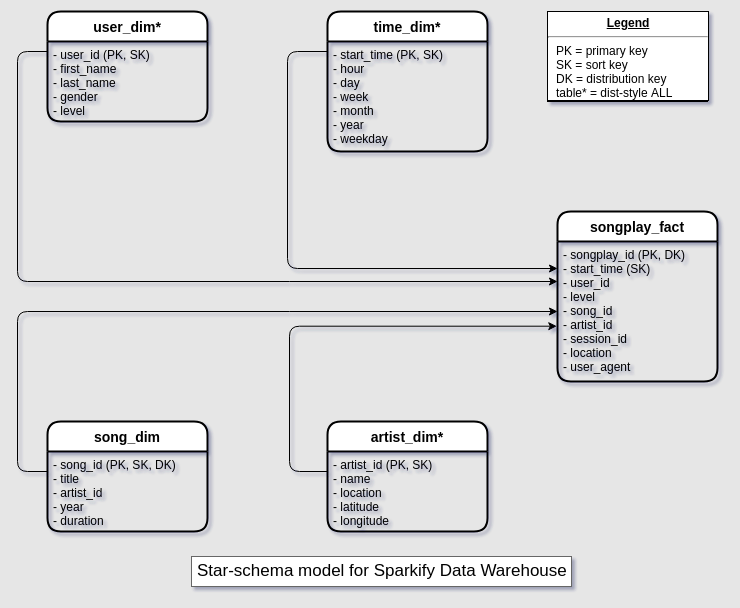

In [18]:
from IPython.display import Image
i = Image(filename='../data_warehouse_redshift/images/Sparkify_DW_background_shadow.png')
i

### Creating song dimension

In [20]:
song_dim = song_data\
            .filter((f.col('song_id').isNotNull()) &
                    (f.col('title').isNotNull()) &
                    (f.col('artist_id').isNotNull()) &
                    (f.col('year').isNotNull()) &
                    (f.col('duration').isNotNull())
                   )\
            .dropDuplicates(subset=['song_id'])\
            .select(['song_id', 'title', 'artist_id', 'year', 'duration'])
song_dim.printSchema()
song_dim.count()

root
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- year: long (nullable = true)
 |-- duration: double (nullable = true)



71

In [21]:
song_dim.groupby('song_id').count().filter(f.col('count')>1).count()

0

### Creating artist dimension

In [22]:
artist_dim = song_data\
                .filter((f.col('artist_id').isNotNull()) &
                        (f.col('artist_name').isNotNull()) 
                       )\
                .dropDuplicates(subset=['artist_id'])\
                .select(['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude'])\
                .withColumnRenamed('artist_name', 'name')\
                .withColumnRenamed('artist_location', 'location')\
                .withColumnRenamed('artist_latitude', 'latitude')\
                .withColumnRenamed('artist_longitude', 'longitude')
artist_dim.printSchema()
artist_dim.count()

root
 |-- artist_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



69

In [23]:
artist_dim.groupby('artist_id').count().filter(f.col('count')>1).count()

0

### Creating user dimension

In [25]:
user_dim = log_data\
                .filter((f.col('userId').isNotNull()) &
                        (f.col('firstName').isNotNull()) &
                        (f.col('lastName').isNotNull()) &
                        (f.col('gender').isNotNull()) &
                        (f.col('level').isNotNull()) &
                        (f.col('page') == 'NextSong')
                )\
                .dropDuplicates(subset=['userId'])\
                .select(
                    f.col('userId').cast(IntegerType()),
                    'firstName', 'lastName', 'gender', 'level', 'page')
user_dim = user_dim\
                .withColumnRenamed('userId', 'user_id')\
                .withColumnRenamed('firstName', 'first_name')\
                .withColumnRenamed('lastName', 'last_name')
user_dim.printSchema()
user_dim.count()

root
 |-- user_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)



96

In [26]:
user_dim.groupby('user_id').count().filter(f.col('count')>1).count()

0

### Creating time dimension

In [27]:
time_dim = log_data\
                .select(f.to_timestamp(f.from_unixtime(f.col('ts')/1000)).alias('start_time'))\
                .filter(f.col('start_time').isNotNull())\
                .dropDuplicates(subset=['start_time'])\
                .withColumn('hour',f.hour('start_time'))\
                .withColumn('day', f.dayofyear('start_time'))\
                .withColumn('week', f.weekofyear('start_time'))\
                .withColumn('month', f.month('start_time'))\
                .withColumn('year', f.year('start_time'))\
                .withColumn('weekday', f.dayofweek('start_time'))
                
time_dim.printSchema()
time_dim.count()

root
 |-- start_time: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekday: integer (nullable = true)



6813

In [28]:
time_dim.groupby('start_time').count().filter(f.col('count')>1).count()

0

In [ ]:
# time_dim.show(20)

### Creating songplay_fact

In [39]:
log_data_part = log_data.select(f.monotonically_increasing_id().alias('songplay_id'),
                                f.to_timestamp(f.from_unixtime(f.col('ts')/1000)).alias('start_time'),
                                f.col('userId').cast(IntegerType()).alias('user_id'),
                                'artist',
                                'song',
                                'level',
                                f.col('sessionId').alias('session_id'),
                                'location',
                                f.col('userAgent').alias('user_agent')
                               )\
                        .withColumn('month', f.month('start_time'))\
                        .withColumn('year', f.year('start_time'))
songplay_fact = log_data_part.join(song_data, 
                                   (song_data.title==log_data_part.song) & (song_data.artist_name == log_data.artist)
                                  )\
                            .select(['songplay_id', 'start_time', 'user_id', 'level',
                                     'song_id', 'artist_id', 'session_id', 'location', 'user_agent',
                                     log_data_part.year, log_data_part.month])
songplay_fact.printSchema()

root
 |-- songplay_id: long (nullable = false)
 |-- start_time: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- level: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- session_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [30]:
song_dim.write.partitionBy(['year', 'artist_id']).mode("overwrite").parquet("/tmp/output/song_dim/")

In [31]:
artist_dim.write.mode("overwrite").parquet("/tmp/output/artist_dim/")

In [32]:
user_dim.write.mode("overwrite").parquet("/tmp/output/user_dim/")

In [34]:
time_dim.write.partitionBy(['year', 'month']).mode("overwrite").parquet("/tmp/output/time_dim/")

In [42]:
songplay_fact.write.partitionBy(['year', 'month']).mode("overwrite").parquet("/tmp/output/songplay_fact/")

In [43]:
songplay_fact.count()

1